<a href="https://colab.research.google.com/github/montimaj/DNR_NDVI/blob/main/Landsat_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrating Remote Sensing and Palynology to analyze modern-day vegetation vigor around the Lake Izabal region, eastern Guatemala; insights from the NDVI proxy.**

*Authors: Erdoo Mongol, Francisca Oboh-Ikuenobe, Jonathan Obrist-Farner, Ryan Smith and Sayantan Majumdar*

Department of Geosciences and Geological and Petroleum Engineering Missouri University of Science and Technology, Rolla MO, USA.

Code Developed by: Erdoo Mongol, Sayantan Majumdar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd 'drive/My Drive/Landsat 4-5'
!ls

/content/drive/.shortcut-targets-by-id/1Ms7QiEZhUT61bI8wuzKrHXmbZbgX7xvE/Landsat 4-5
 Landsat4_5   Landsat_NDVI.ipynb   NDVI		  NDVI_Reproj
'Landsat 8'   Mean_NDVI		   NDVI_CSV.csv   Plots


In [6]:
!pip install rasterio

     |████████████████████████████████| 18.3MB 233kB/s 


In [7]:
import rasterio as rio
import numpy as np
import glob

In [8]:
NO_DATA_VALUE = -32767.0

In [9]:
def read_raster_as_arr(raster_file, band=1, get_file=True, rasterio_obj=False, change_dtype=True):
    """
    Get raster array
    :param raster_file: Input raster file path
    :param band: Selected band to read (Default 1)
    :param get_file: Get rasterio object file if set to True
    :param rasterio_obj: Set true if raster_file is a rasterio object
    :param change_dtype: Change raster data type to float if true
    :return: Raster numpy array and rasterio object file (get_file=True and rasterio_obj=False)
    """

    if not rasterio_obj:
        raster_file = rio.open(raster_file)
    else:
        get_file = False
    raster_arr = raster_file.read(band)
    if change_dtype:
        raster_arr = raster_arr.astype(np.float32)
        if raster_file.nodata:
            raster_arr[np.isclose(raster_arr, raster_file.nodata)] = np.nan
    if get_file:
        return raster_arr, raster_file
    return raster_arr


def write_raster(raster_data, raster_file, transform, outfile_path, no_data_value=NO_DATA_VALUE,
                 ref_file=None):
    """
    Write raster file in GeoTIFF format
    :param raster_data: Raster data to be written
    :param raster_file: Original rasterio raster file containing geo-coordinates
    :param transform: Affine transformation matrix
    :param outfile_path: Outfile file path
    :param no_data_value: No data value for raster (default float32 type is considered)
    :param ref_file: Write output raster considering parameters from reference raster file
    :return: None
    """
    if ref_file:
        raster_file = rio.open(ref_file)
        transform = raster_file.transform
    with rio.open(
            outfile_path,
            'w',
            driver='GTiff',
            height=raster_data.shape[0],
            width=raster_data.shape[1],
            dtype=raster_data.dtype,
            crs=raster_file.crs,
            transform=transform,
            count=raster_file.count,
            nodata=no_data_value
    ) as dst:
        dst.write(raster_data, raster_file.count)

In [10]:
import re
import os

In [11]:
def create_ndvi_rasters(input_dir, sensor='L8'):
  """
  :param input_dir: Input directory
  :param sensor: Landsat 8 sensor is default, change to L4 for Landsat 4 or 5
  :return: None
  """
  
  landsat_files = glob.glob(input_dir + '*')
  landsat_file_name = landsat_files[0][landsat_files[0].rfind('/') + 1:]
  underscore_pos = [m.start() for m in re.finditer('_', landsat_file_name)]
  output_dir = 'NDVI/'
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  red_band_pos = 4
  if sensor != 'L8':
    red_band_pos = 3
  nir_band_pos = red_band_pos + 1
  for landsat_file in landsat_files:
    landsat_file_name = landsat_file[landsat_file.rfind('/') + 1:]
    dt = landsat_file_name[underscore_pos[2] + 1: underscore_pos[3]]
    red_band_file = glob.glob(landsat_file + '/*B' + str(red_band_pos) + '.TIF')[0]
    nir_band_file = glob.glob(landsat_file + '/*B' + str(nir_band_pos) + '.TIF')[0]
    red_arr, red_file = read_raster_as_arr(red_band_file)
    nir_arr = read_raster_as_arr(nir_band_file, get_file=False)
    ndvi_arr = (nir_arr - red_arr) / (nir_arr + red_arr)
    ndvi_arr[np.isnan(ndvi_arr)] = NO_DATA_VALUE
    output_file = output_dir + 'NDVI_' + dt + '.tif'
    print('Writing', output_file, '...')
    write_raster(ndvi_arr, red_file, transform=red_file.transform, outfile_path=output_file)

In [ ]:
create_ndvi_rasters('Landsat 8/')
create_ndvi_rasters('Landsat4_5/', sensor='L4')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Writing NDVI/NDVI_20181031.tif ...
Writing NDVI/NDVI_20161002.tif ...
Writing NDVI/NDVI_20170327.tif ...
Writing NDVI/NDVI_20171021.tif ...
Writing NDVI/NDVI_20180321.tif ...
Writing NDVI/NDVI_20160315.tif ...
Writing NDVI/NDVI_19910320.tif ...
Writing NDVI/NDVI_19900512.tif ...
Writing NDVI/NDVI_19891007.tif ...
Writing NDVI/NDVI_19911030.tif ...
Writing NDVI/NDVI_19891227.tif ...
Writing NDVI/NDVI_19900301.tif ...


In [12]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt

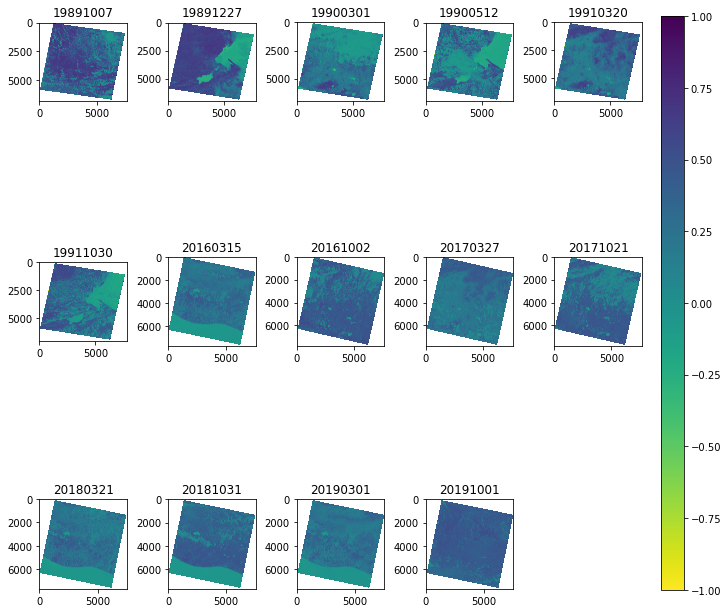

In [18]:
ndvi_files = sorted(glob.glob('NDVI/*.tif'))
fig1, f1_axes = plt.subplots(ncols=5, nrows=3, figsize=(10, 10), constrained_layout=True)
f1_axes = f1_axes.ravel()
for idx, ndvi_file in enumerate(ndvi_files):
  ndvi_arr = read_raster_as_arr(ndvi_file, get_file=False)
  ax = f1_axes[idx]
  dt = ndvi_file[ndvi_file.rfind('_') + 1: ndvi_file.rfind('.')]
  ax.set_title(dt)
  img = ax.imshow(ndvi_arr, cmap='viridis_r')
fig1.delaxes(f1_axes[-1])
fig1.colorbar(img, ax=f1_axes.tolist(), shrink=0.8)

In [19]:
if not os.path.exists('Plots'):
  os.makedirs('Plots')

In [20]:
fig1.savefig('Plots/NDVI_All_Plot.svg')

In [15]:
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import glob
import os
import numpy as np

In [16]:
def create_mean_annual_ndvi_rasters(ndvi_dir):
  """
  :param ndvi_dir: Input ndvi directory
  """

  year_dict = {}
  ndvi_files = glob.glob(ndvi_dir + '*.tif')
  output_dir = 'Mean_NDVI/'
  reproj_dir = 'NDVI_Reproj/'
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  if not os.path.exists(reproj_dir):
    os.makedirs(reproj_dir)
  for ndvi_file in ndvi_files:
    underscore_pos = ndvi_file.rfind('_')
    year = ndvi_file[underscore_pos + 1: underscore_pos + 5]
    if year not in year_dict.keys():
      year_dict[year], raster_file = read_raster_as_arr(ndvi_file)
    else:
      src_ndvi_arr, src_file = read_raster_as_arr(ndvi_file)
      print('Reprojecting', ndvi_file, '...')
      ndvi_arr, _ = reproject(src_ndvi_arr, np.copy(year_dict[year]), src_crs=src_file.crs, src_transform=src_file.transform, dst_transform=src_file.transform,
                    dst_crs=src_file.crs, resampling=Resampling.nearest, src_nodata=np.nan, dst_nodata=np.nan)
      ndvi_arr[np.isnan(ndvi_arr)] = NO_DATA_VALUE
      write_raster(ndvi_arr, raster_file, transform=raster_file.transform, outfile_path=reproj_dir + 'Reproj_' + year + '.tif')
      ndvi_arr[ndvi_arr == NO_DATA_VALUE] = np.nan
      year_dict[year] = (year_dict[year] +  ndvi_arr) / 2
  for year in year_dict.keys():
    output_file = output_dir + 'Mean_NDVI_' + year + '.tif'
    print('Writing', output_file, '...')
    ndvi_arr = year_dict[year]
    ndvi_arr[np.isnan(ndvi_arr)] = NO_DATA_VALUE
    write_raster(ndvi_arr, raster_file, transform=raster_file.transform, outfile_path=output_file)

In [ ]:
create_mean_annual_ndvi_rasters('NDVI/')

Reprojecting NDVI/NDVI_20171021.tif ...
Reprojecting NDVI/NDVI_20180321.tif ...
Reprojecting NDVI/NDVI_20160315.tif ...
Reprojecting NDVI/NDVI_19911030.tif ...
Reprojecting NDVI/NDVI_19891227.tif ...
Reprojecting NDVI/NDVI_19900301.tif ...
Reprojecting NDVI/NDVI_20191001.tif ...
Writing Mean_NDVI/Mean_NDVI_2018.tif ...
Writing Mean_NDVI/Mean_NDVI_2016.tif ...
Writing Mean_NDVI/Mean_NDVI_2017.tif ...
Writing Mean_NDVI/Mean_NDVI_1991.tif ...
Writing Mean_NDVI/Mean_NDVI_1990.tif ...
Writing Mean_NDVI/Mean_NDVI_1989.tif ...
Writing Mean_NDVI/Mean_NDVI_2019.tif ...


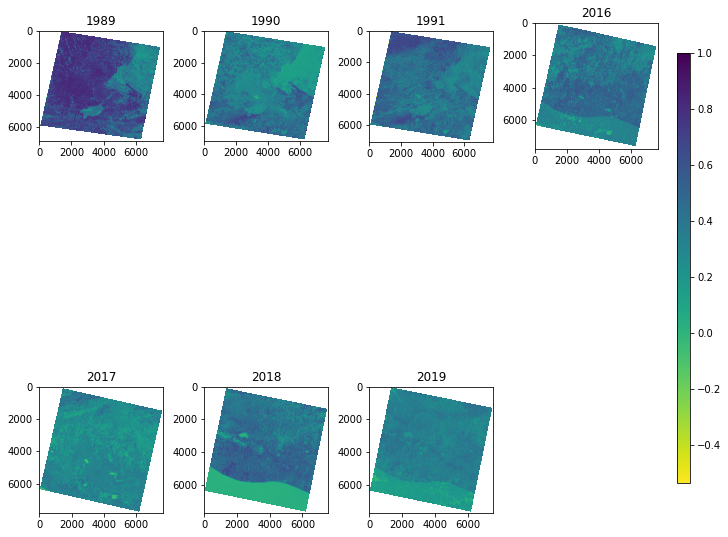

In [17]:
import matplotlib.pyplot as plt

ndvi_files = sorted(glob.glob('Mean_NDVI/*.tif'))
fig1, f1_axes = plt.subplots(ncols=4, nrows=2, figsize=(10, 10), constrained_layout=True)
f1_axes = f1_axes.ravel()
for idx, ndvi_file in enumerate(ndvi_files):
  ndvi_arr = read_raster_as_arr(ndvi_file, get_file=False)
  ax = f1_axes[idx]
  dt = ndvi_file[ndvi_file.rfind('_') + 1: ndvi_file.rfind('.')]
  ax.set_title(dt)
  img = ax.imshow(ndvi_arr, cmap='viridis_r')
fig1.delaxes(f1_axes[-1])
fig1.colorbar(img, ax=f1_axes.tolist(), shrink=0.6)
fig1.savefig('Plots/Mean_Annual_NDVI.svg')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

ndvi_files = sorted(glob.glob('Mean_NDVI/*.tif'))
ndvi_list, year_list = [], []
for ndvi_file in ndvi_files:
  year = ndvi_file[ndvi_file.rfind('_') + 1: ndvi_file.rfind('.')]
  ndvi_list.append(np.nanmean(read_raster_as_arr(ndvi_file, get_file=False)))
  year_list.append(int(year))
ndvi_dict = {'YEAR': year_list, 'Mean_NDVI': ndvi_list}
df = pd.DataFrame(data=ndvi_dict)
df.to_csv('NDVI_CSV.csv', index=False)

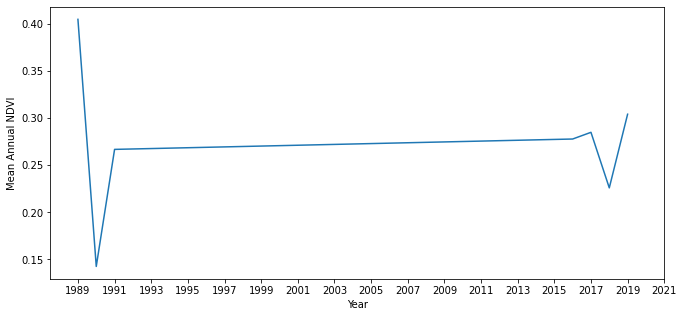

In [ ]:
plt.plot(year_list, ndvi_list)
plt.ylabel('Mean Annual NDVI')
plt.xlabel('Year')
plt.xticks(np.arange(1989, 2022, 2))
fig = plt.gcf()
fig.set_size_inches(11,5)
fig.savefig('Plots/Mean_Plot.svg')